#### EDA notebook - Arnab

In [1]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

from scipy.stats import spearmanr
from scipy.cluster import hierarchy

from boruta import BorutaPy

from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from collections import defaultdict

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount("/content/drive")

%cd "/content/drive/My Drive/omdena-data/newdata"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/omdena-data/newdata


In [0]:
# read data
df = pd.read_csv("OUTPUT_WBI_exposer_cyclones_v2.csv", sep=";")

In [4]:
# features
df.columns

Index(['SID', 'NAME', 'ISO', 'YEAR', 'BASIN', 'SUB BASIN', 'NATURE',
       'ISO_TIME', 'COORDS', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'USA_SSHS',
       'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN',
       'V_LAND_KN', '34KN_POP', '34KN_ASSETS', '64KN_POP', '64KN_ASSETS',
       '96KN_POP', '96KN_ASSETS', 'CPI', 'TOTAL_DAMAGE_(000$)', 'TOTAL_DEATHS',
       'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
       'pop_max_34_adj', 'pop_max_50_

In [0]:
# drop rows with NaN
df.dropna(inplace = True)

In [0]:
# convert 'Income_level_Final' feature to integer
unique_list = df['Income_level_Final'].unique()
incomelevel_to_int = dict(zip(unique_list, range(1, len(unique_list)+1)))
df['Income_level_Final'] = df['Income_level_Final'].apply(lambda inc_level: incomelevel_to_int[inc_level])

In [0]:
# choosing some numeric features - more or less arbitrary. Include more columns as deemed necessary.
keep_cols = ['TOTAL_AFFECTED', 'TOTAL_HRS', 'USA_SSHS', 'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN',
             'V_LAND_KN', 'Population density (people per sq. km of land area)',
             'Rural population (% of total population)', 'Income_level_Final', 'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_adj']
df = df[keep_cols]
# df['pop_max_34_adj'] = df['pop_max_34_adj']*0.5 + df['pop_max_50_adj']*0.3 + df['pop_max_64_adj']*0.2
# df['pop_max_64_adj'] = df['pop_max_34_adj'] - df['pop_max_64_adj']
# df.drop(columns=['pop_max_50_adj', 'pop_max_64_adj'], inplace=True)


In [0]:
# save the list of columns for later
cols = df.columns

In [0]:
# scale the features
min_max_scaler = preprocessing.MinMaxScaler()
X = df.values
x_scaled = min_max_scaler.fit_transform(X)
df = pd.DataFrame(x_scaled)
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values.ravel()

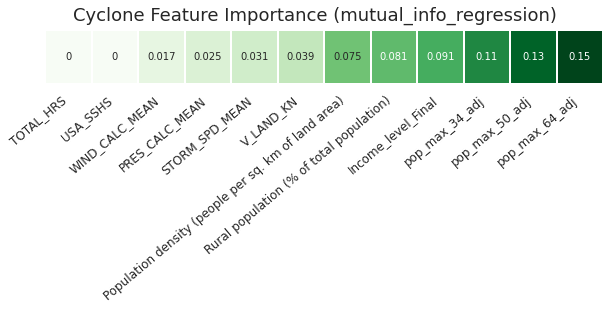

In [12]:
# feature importance using mutual_info_regression - https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html
# reference: https://www.kaggle.com/residentmario/automated-feature-selection-with-sklearn
# higher values mean higher dependency of the target feature on the input feature

cyclone_mutual_information = np.sort(mutual_info_regression(X, y))
plt.subplots(1, figsize=(10, 1))
sns.heatmap(cyclone_mutual_information[:, np.newaxis].T, cmap='Greens', cbar=False, linewidths=1, annot=True)
plt.yticks([], [])
plt.gca().set_xticklabels(cols[1:], rotation=40, ha='right', fontsize=12)
plt.suptitle("Cyclone Feature Importance (mutual_info_regression)", fontsize=18, y=1.2)
plt.gcf().subplots_adjust(wspace=0.2)

In [13]:
# select K best features ***caveat: based on univariate statistical tests.
trans = SelectKBest(score_func=f_regression, k=10)
X_trans = trans.fit_transform(X, y)
columns_retained_Select = cols[1:][trans.get_support()].values
subset_df = pd.DataFrame(X_trans, columns=columns_retained_Select)
subset_df.columns

Index(['TOTAL_HRS', 'WIND_CALC_MEAN', 'STORM_SPD_MEAN', 'V_LAND_KN',
       'Population density (people per sq. km of land area)',
       'Rural population (% of total population)', 'Income_level_Final',
       'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_adj'],
      dtype='object')

In [0]:
# # reference: https://www.kaggle.com/residentmario/automated-feature-selection-with-sklearn
# trans = GenericUnivariateSelect(score_func=mutual_info_regression, mode='percentile', param=90)
# X_trans = trans.fit_transform(X, y)
# columns_retained_Select = cols[1:][trans.get_support()].values
# subset_df = pd.DataFrame(X_trans, columns=columns_retained_Select)

# # let's see the features retained after keeping 90% - it matches the above list after dropping the ones with zero importance
# subset_df.columns

R-squared: 0.87


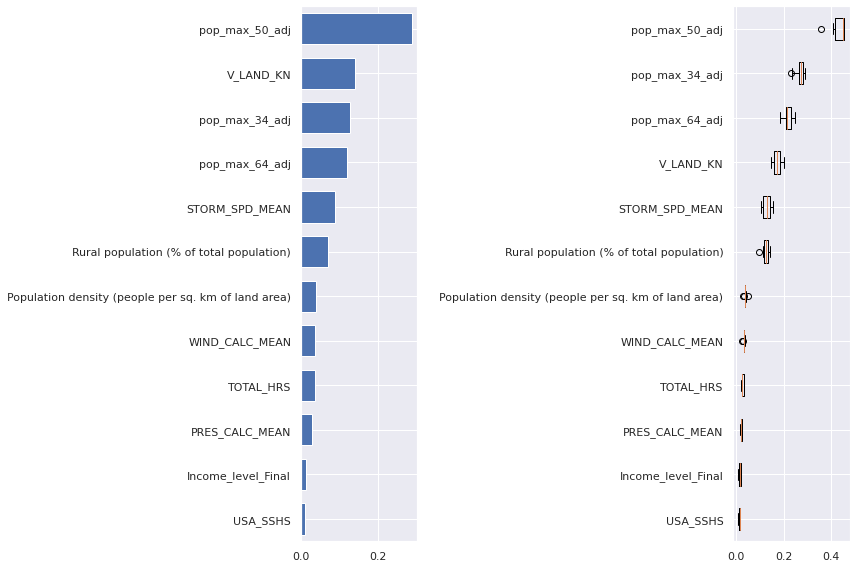

In [15]:
"""
reference:
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py
"""
"""
the permutation importance plot suggests how much at most the accuracy will drop by permuting the respective feature.
looks like these features are not multicollinear (which is good)
from the dendogram plot, we can maybe drop one feature from each cluster. But I'm already using a minimal set of features to begin with.
"""
features = cols[1:]

clf = RandomForestRegressor(n_estimators=100, random_state=42)
clf.fit(X, y)
print(f"R-squared: {clf.score(X, y):.2f}")

result = permutation_importance(clf, X, y, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(features[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=features[perm_sorted_idx])
fig.tight_layout()
plt.show()

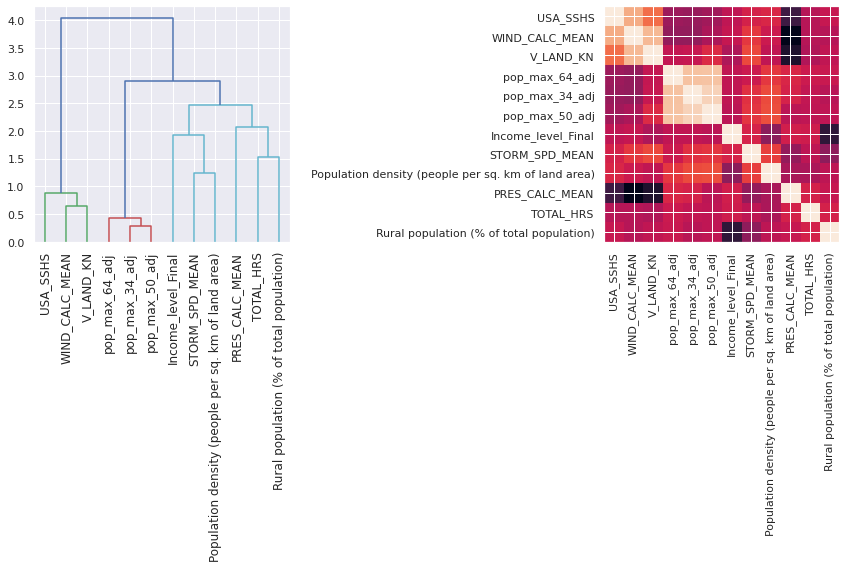

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=features, ax=ax1,
                              leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()


### TODO: Explain the dendogram chart.

#### Boruta package - feature selector

In [0]:
%%capture

"""
reference: Geetanjali's notebook
"""
# use the boruta feature selector with RandomForestRegressor as the base estimator
reg = RandomForestRegressor(n_estimators=100, random_state=42)
boruta_feature_selector = BorutaPy(reg, n_estimators='auto', verbose=2, random_state=4242, max_iter = 100, perc = 60) # not sure what the perc param does??
boruta_feature_selector.fit(X, y)

In [18]:
# get the list of features selected
final_features = []
indexes = np.where(boruta_feature_selector.support_ == True)
for x in np.nditer(indexes):
    final_features.append(cols[x])
print(final_features)

['PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'Population density (people per sq. km of land area)', 'Income_level_Final', 'pop_max_34_adj', 'pop_max_50_adj']


#### mlxtend

In [0]:
%%capture
"""
reference: http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/
"""

cv = KFold(n_splits=5, shuffle=True, random_state=17)
reg = LinearRegression()
sbs = SequentialFeatureSelector(reg, 
           k_features=(1, 12),                  
           forward=False, 
           floating=False, 
           verbose=2,
           scoring='r2',
           cv=cv)
X_sbs = sbs.fit_transform(X, y, custom_feature_names=cols[1:])


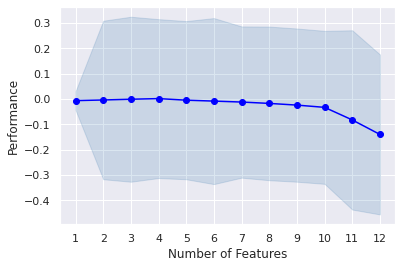

In [27]:
plot_sfs(sbs.get_metric_dict(), kind='std_dev');

In [21]:
# subset of selected feature names:
sbs.k_feature_names_

('STORM_SPD_MEAN',
 'Population density (people per sq. km of land area)',
 'Rural population (% of total population)',
 'pop_max_50_adj')

In [42]:
X_sbs.shape

(438, 4)

In [43]:
sbs.k_feature_names_

('STORM_SPD_MEAN',
 'Population density (people per sq. km of land area)',
 'Rural population (% of total population)',
 'pop_max_50_adj')